## Imports

In [1]:
import os
from PIL import Image
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import timm
from timm import create_model

from tqdm import tqdm

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Exploration

In [2]:
# Define dataset root
dataset_path = "/kaggle/input/commontest01/dataset/val"
save_dir = "/kaggle/working/"

# Class names
class_names = ["no", "sphere", "vort"]

# Storage for stats
shape_counts = {}
class_counts = {name: 0 for name in class_names}
pixel_values = []

# Iterate through classes
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.exists(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith(".npy"):
                file_path = os.path.join(class_dir, file)
                img = np.load(file_path)  # Load numpy array

                # Track shapes
                shape = img.shape
                shape_counts[shape] = shape_counts.get(shape, 0) + 1

                # Track min/max pixel values
                pixel_values.append((img.min(), img.max()))

                # Count class samples
                class_counts[class_name] += 1

# Print findings
print("✅ Image Shape Distribution:", shape_counts)
print("✅ Class Distribution:", class_counts)
print("✅ Pixel Value Ranges:", set(pixel_values))


✅ Image Shape Distribution: {(1, 150, 150): 7500}
✅ Class Distribution: {'no': 2500, 'sphere': 2500, 'vort': 2500}
✅ Pixel Value Ranges: {(0.0, 1.0)}


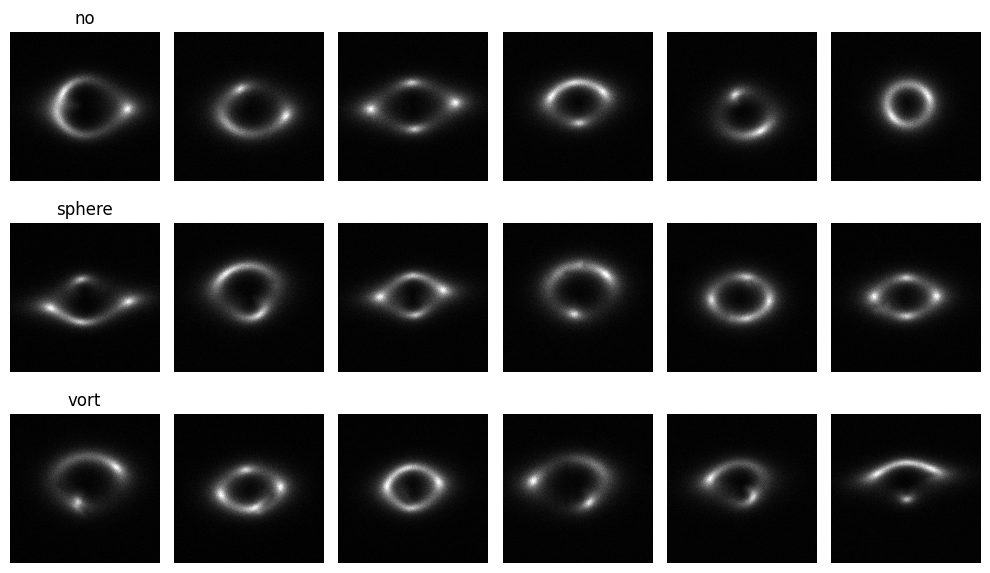

In [3]:
# Function to display images
def show_sample_images(dataset_path, class_names, num_samples=6):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(10, 6))
    
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        files = [f for f in os.listdir(class_dir) if f.endswith(".npy")]
        
        for j in range(num_samples):
            img = np.load(os.path.join(class_dir, files[j]))
            img = img.squeeze()  # Remove channel dim (1, H, W) -> (H, W)
            
            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'samples.png'))
    
    plt.show()

# Show samples
show_sample_images(dataset_path, class_names)

## Helpful

In [4]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

def plot_tensor_image(tensor, title="Image"):
    """
    Plots a PyTorch tensor as an image.
    
    Args:
        tensor (torch.Tensor): Image tensor of shape (C, H, W) or (H, W).
        title (str): Title of the plot.
    """
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu()  # Ensure it's on CPU and detached from the graph
    
    if tensor.ndim == 3 and tensor.shape[0] in [1, 3]:  # (C, H, W) format
        tensor = tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    elif tensor.ndim == 2:  # Grayscale image (H, W)
        tensor = tensor.numpy()
    
    # Normalize if needed (convert values to range [0,1])
    if tensor.max() > 1:
        tensor = tensor / 255.0  

    plt.imshow(tensor, cmap="gray" if tensor.shape[-1] == 1 else None)
    plt.axis("off")
    plt.title(title)
    plt.show()

## DataLoader

In [5]:
class NumpyImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, repeating_channels=True):
        self.root_dir = root_dir
        self.transform = transform
        self.repeating_channels = repeating_channels
        self.samples = []
        self.label_map = {"no": 0, "sphere": 1, "vort": 2}  # Class mapping

        # Collect all .npy file paths and labels
        for class_name, label in self.label_map.items():
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                for file in os.listdir(class_path):
                    if file.endswith(".npy"):
                        self.samples.append((os.path.join(class_path, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        img = np.load(file_path)  # Load (1, H, W) array

        # Convert (1, H, W) -> (H, W, 3) by repeating channels
        if self.repeating_channels:
            img = np.repeat(img, 3, axis=0)  # Now (3, H, W)
        # print(img.shape, type(img))
        img = np.transpose(img, (1, 2, 0))  # (H, W, 3)
        img = Image.fromarray(np.uint8(img * 255))  # Ensure it's scaled correctly if needed
        # print(type(img))

        # Apply optional transformations
        if self.transform:
            img = self.transform(img)
        # print(img.shape)
        return img, label

## Model Architecture

### baby model

In [6]:
class LensModel(nn.Module):
    """
    A PyTorch neural network model for classifying images based on lens type.

    Args:
        num_classes (int): The number of classes to classify.
        in_channels (int, optional): The number of input channels. Defaults to 1.

    Attributes:
        conv1 (nn.Conv2d): The first convolutional layer.
        bn1 (nn.BatchNorm2d): The first batch normalization layer.
        relu1 (nn.ReLU): The first ReLU activation layer.
        conv2 (nn.Conv2d): The second convolutional layer.
        bn2 (nn.BatchNorm2d): The second batch normalization layer.
        relu2 (nn.ReLU): The second ReLU activation layer.
        pool (nn.AdaptiveAvgPool2d): The adaptive average pooling layer.
        fc (nn.Linear): The fully connected output layer.
        softmax (nn.Softmax): The softmax activation layer.

    """
    def __init__(self, num_classes, in_channels=1):
        super(LensModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(inplace=True)
        
        #self.conv3 = nn.Conv2d(in_channels=128, out_channels=1024, kernel_size=3, stride=1, padding=1)
        #self.bn3 = nn.BatchNorm2d(1024)
        #self.relu3 = nn.ReLU(inplace=True)
        
        #self.conv4 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, stride=1, padding=1)
        #self.bn4 = nn.BatchNorm2d(256)
        #self.relu4 = nn.ReLU(inplace=True)

        #self.conv5 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, stride=1, padding=1)
        #self.bn5 = nn.BatchNorm2d(256)
        #self.relu5 = nn.ReLU(inplace=True)

        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=256, out_features=num_classes)

        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        """
        Compute forward pass through the neural network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        #x = self.relu3(self.bn3(self.conv3(x)))
        #x = self.relu4(self.bn4(self.conv4(x)))
        #x = self.relu5(self.bn5(self.conv5(x)))

        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

### PreTrained Models

In [7]:
def modify_vit_for_grayscale(vit_model):
    """
    Modifies a Vision Transformer (ViT) model to accept grayscale (1-channel) images instead of RGB (3-channel).

    Args:
        vit_model: Pretrained ViT model from timm or torchvision.

    Returns:
        Modified ViT model.
    """
    # Get the patch embedding layer
    patch_embed = vit_model.patch_embed

    # Create a new layer with input channel changed from 3 → 1
    new_patch_embed = torch.nn.Conv2d(
        in_channels=1,  # Change input channels to 1 (grayscale)
        out_channels=patch_embed.proj.out_channels,  # Keep the same output channels
        kernel_size=patch_embed.proj.kernel_size,  # Keep the kernel size
        stride=patch_embed.proj.stride,  # Keep the stride
        padding=patch_embed.proj.padding,  # Keep the padding
        bias=patch_embed.proj.bias is not None  # Keep bias settings
    )

    # Copy weights by averaging across RGB channels
    with torch.no_grad():
        new_patch_embed.weight[:] = patch_embed.proj.weight.mean(dim=1, keepdim=True)

    # Replace the old patch embedding layer
    vit_model.patch_embed.proj = new_patch_embed

    return vit_model

class Classifiervit(nn.Module):
    def __init__(self, num_classes=3, p=0.5, repeating_channels=True):
        super(Classifiervit, self).__init__()
        if repeating_channels:
            self.model = create_model("vit_tiny_patch16_224", pretrained=True)
        else:
            self.model = modify_vit_for_grayscale(create_model("vit_tiny_patch16_224", pretrained=True))

        self.fc1 = nn.Linear(1000, 128)
        # self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        x = self.model(x)
        x = self.relu(self.bn(self.fc1(x)))
        x = self.dropout(x)
        # x = self.relu(self.bn(self.fc2(x)))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x


In [8]:
class ClassifierRes(nn.Module):
    def __init__(self, num_classes=3, p=0.5):
        super(ClassifierRes, self).__init__()
        
        inception_resnet_v2 = timm.create_model('inception_resnet_v2', pretrained=True)
        self.inc_base = nn.Sequential(*list(inception_resnet_v2.children())[:-1])
        self.feature_vector = 1536

        self.num_classes = num_classes

        self.fc1 = nn.Linear(self.feature_vector, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        x = self.inc_base(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Trainning

In [9]:
torch.cuda.empty_cache()

In [10]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

val_transforms = transforms.Compose([
        transforms.CenterCrop(100),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
train_dataset_path = "/kaggle/input/commontest01/dataset/train"
val_dataset_path = "/kaggle/input/commontest01/dataset/val"
train_dataset = NumpyImageDataset(train_dataset_path, transform=train_transforms)
val_dataset = NumpyImageDataset(val_dataset_path, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

# 🔹 Load Modified ViT Model (for grayscale)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3

In [11]:
model = Classifiervit()
print_trainable_parameters(model)
model = nn.DataParallel(model.to(device))

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

trainable params: 5846187 || all params: 5846187 || trainable%: 100.0


In [12]:
# 🔹 Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-4) # , weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss()

# Track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_aucs, val_aucs = [], []

# 🔹 Training Loop
num_epochs = 150
best_val_auc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_probs = []
    all_labels = []

    for batch_data, batch_labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)
        probs = torch.softmax(outputs, dim=1) # [:, 1]  # Probability for class 1
        all_probs.extend(probs.cpu().detach().numpy())
        all_labels.extend(batch_labels.cpu().numpy())


    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    try:
        train_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except ValueError:
        train_auc = float('nan')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_aucs.append(train_auc)

    # 🔹 Validation Step
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0.0
    all_probs_test = []
    all_labels_test = []

    with torch.no_grad():
        for batch_data, batch_labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == batch_labels).sum().item()
            val_total += batch_labels.size(0)

            # Collect probabilities and labels for ROC/AUC
            probs = torch.softmax(outputs, dim=1) # [:, 1]  # Probability for class 1
            all_probs_test.extend(probs.cpu().detach().numpy())
            all_labels_test.extend(batch_labels.cpu().numpy())
    
    val_acc = val_correct / val_total
    val_loss = val_loss / len(val_loader)
    scheduler.step(val_loss)

    try:
        val_auc = roc_auc_score(all_labels_test, all_probs_test, multi_class='ovr')
    except ValueError:
        val_auc = float('nan') 

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},  Train AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

    # 🔹 Save Best Model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_vit_model.pth")
        print("✅ Model Saved (Best Validation Accuracy)")

print("🎉 Training Complete!")

Epoch 1/150: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Epoch [1/150] | Train Loss: 1.1358, Train Acc: 0.3660,  Train AUC: 0.5447 | Val Loss: 1.0512, Val Acc: 0.4497, Val AUC: 0.6617
✅ Model Saved (Best Validation Accuracy)


Epoch 2/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [2/150] | Train Loss: 0.9860, Train Acc: 0.5015,  Train AUC: 0.6912 | Val Loss: 0.9010, Val Acc: 0.5709, Val AUC: 0.7557
✅ Model Saved (Best Validation Accuracy)


Epoch 3/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [3/150] | Train Loss: 0.8723, Train Acc: 0.5887,  Train AUC: 0.7729 | Val Loss: 0.8798, Val Acc: 0.5865, Val AUC: 0.8111
✅ Model Saved (Best Validation Accuracy)


Epoch 4/150: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Epoch [4/150] | Train Loss: 0.7802, Train Acc: 0.6528,  Train AUC: 0.8244 | Val Loss: 0.7740, Val Acc: 0.6597, Val AUC: 0.8490
✅ Model Saved (Best Validation Accuracy)


Epoch 5/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [5/150] | Train Loss: 0.7158, Train Acc: 0.6874,  Train AUC: 0.8531 | Val Loss: 0.6831, Val Acc: 0.6960, Val AUC: 0.8698
✅ Model Saved (Best Validation Accuracy)


Epoch 6/150: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Epoch [6/150] | Train Loss: 0.6663, Train Acc: 0.7144,  Train AUC: 0.8725 | Val Loss: 0.6542, Val Acc: 0.7237, Val AUC: 0.8804
✅ Model Saved (Best Validation Accuracy)


Epoch 7/150: 100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


Epoch [7/150] | Train Loss: 0.6282, Train Acc: 0.7361,  Train AUC: 0.8874 | Val Loss: 0.6182, Val Acc: 0.7479, Val AUC: 0.8989
✅ Model Saved (Best Validation Accuracy)


Epoch 8/150: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Epoch [8/150] | Train Loss: 0.5957, Train Acc: 0.7517,  Train AUC: 0.8985 | Val Loss: 0.6865, Val Acc: 0.6856, Val AUC: 0.8947


Epoch 9/150: 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


Epoch [9/150] | Train Loss: 0.5659, Train Acc: 0.7680,  Train AUC: 0.9092 | Val Loss: 0.5704, Val Acc: 0.7732, Val AUC: 0.9159
✅ Model Saved (Best Validation Accuracy)


Epoch 10/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [10/150] | Train Loss: 0.5419, Train Acc: 0.7801,  Train AUC: 0.9162 | Val Loss: 0.6649, Val Acc: 0.7007, Val AUC: 0.9105


Epoch 11/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [11/150] | Train Loss: 0.5241, Train Acc: 0.7876,  Train AUC: 0.9219 | Val Loss: 0.5910, Val Acc: 0.7499, Val AUC: 0.9204
✅ Model Saved (Best Validation Accuracy)


Epoch 12/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [12/150] | Train Loss: 0.4925, Train Acc: 0.8016,  Train AUC: 0.9308 | Val Loss: 0.5443, Val Acc: 0.7885, Val AUC: 0.9304
✅ Model Saved (Best Validation Accuracy)


Epoch 13/150: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Epoch [13/150] | Train Loss: 0.4774, Train Acc: 0.8109,  Train AUC: 0.9348 | Val Loss: 0.4790, Val Acc: 0.8036, Val AUC: 0.9366
✅ Model Saved (Best Validation Accuracy)


Epoch 14/150: 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


Epoch [14/150] | Train Loss: 0.4590, Train Acc: 0.8206,  Train AUC: 0.9394 | Val Loss: 0.4595, Val Acc: 0.8189, Val AUC: 0.9410
✅ Model Saved (Best Validation Accuracy)


Epoch 15/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [15/150] | Train Loss: 0.4493, Train Acc: 0.8225,  Train AUC: 0.9416 | Val Loss: 0.5308, Val Acc: 0.7725, Val AUC: 0.9395


Epoch 16/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [16/150] | Train Loss: 0.4338, Train Acc: 0.8295,  Train AUC: 0.9452 | Val Loss: 0.5054, Val Acc: 0.7896, Val AUC: 0.9426
✅ Model Saved (Best Validation Accuracy)


Epoch 17/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [17/150] | Train Loss: 0.4266, Train Acc: 0.8340,  Train AUC: 0.9478 | Val Loss: 0.4570, Val Acc: 0.8169, Val AUC: 0.9470
✅ Model Saved (Best Validation Accuracy)


Epoch 18/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [18/150] | Train Loss: 0.4112, Train Acc: 0.8402,  Train AUC: 0.9507 | Val Loss: 0.4067, Val Acc: 0.8371, Val AUC: 0.9535
✅ Model Saved (Best Validation Accuracy)


Epoch 19/150: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Epoch [19/150] | Train Loss: 0.4033, Train Acc: 0.8446,  Train AUC: 0.9525 | Val Loss: 0.4163, Val Acc: 0.8340, Val AUC: 0.9537
✅ Model Saved (Best Validation Accuracy)


Epoch 20/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [20/150] | Train Loss: 0.3913, Train Acc: 0.8498,  Train AUC: 0.9553 | Val Loss: 0.4572, Val Acc: 0.8107, Val AUC: 0.9547
✅ Model Saved (Best Validation Accuracy)


Epoch 21/150: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [21/150] | Train Loss: 0.3846, Train Acc: 0.8518,  Train AUC: 0.9569 | Val Loss: 0.3919, Val Acc: 0.8476, Val AUC: 0.9574
✅ Model Saved (Best Validation Accuracy)


Epoch 22/150: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


Epoch [22/150] | Train Loss: 0.3751, Train Acc: 0.8583,  Train AUC: 0.9589 | Val Loss: 0.3807, Val Acc: 0.8499, Val AUC: 0.9578
✅ Model Saved (Best Validation Accuracy)


Epoch 23/150: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


Epoch [23/150] | Train Loss: 0.3625, Train Acc: 0.8624,  Train AUC: 0.9615 | Val Loss: 0.3722, Val Acc: 0.8621, Val AUC: 0.9631
✅ Model Saved (Best Validation Accuracy)


Epoch 24/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [24/150] | Train Loss: 0.3582, Train Acc: 0.8617,  Train AUC: 0.9623 | Val Loss: 0.3801, Val Acc: 0.8515, Val AUC: 0.9612


Epoch 25/150: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


Epoch [25/150] | Train Loss: 0.3537, Train Acc: 0.8664,  Train AUC: 0.9629 | Val Loss: 0.3428, Val Acc: 0.8719, Val AUC: 0.9658
✅ Model Saved (Best Validation Accuracy)


Epoch 26/150: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


Epoch [26/150] | Train Loss: 0.3448, Train Acc: 0.8693,  Train AUC: 0.9655 | Val Loss: 0.3782, Val Acc: 0.8571, Val AUC: 0.9608


Epoch 27/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [27/150] | Train Loss: 0.3385, Train Acc: 0.8721,  Train AUC: 0.9660 | Val Loss: 0.3669, Val Acc: 0.8623, Val AUC: 0.9649


Epoch 28/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [28/150] | Train Loss: 0.3302, Train Acc: 0.8748,  Train AUC: 0.9676 | Val Loss: 0.4399, Val Acc: 0.8488, Val AUC: 0.9626


Epoch 29/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [29/150] | Train Loss: 0.3303, Train Acc: 0.8758,  Train AUC: 0.9676 | Val Loss: 0.3363, Val Acc: 0.8721, Val AUC: 0.9687
✅ Model Saved (Best Validation Accuracy)


Epoch 30/150: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Epoch [30/150] | Train Loss: 0.3192, Train Acc: 0.8796,  Train AUC: 0.9698 | Val Loss: 0.3878, Val Acc: 0.8524, Val AUC: 0.9658


Epoch 31/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [31/150] | Train Loss: 0.3097, Train Acc: 0.8844,  Train AUC: 0.9715 | Val Loss: 0.3655, Val Acc: 0.8609, Val AUC: 0.9699
✅ Model Saved (Best Validation Accuracy)


Epoch 32/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [32/150] | Train Loss: 0.3059, Train Acc: 0.8847,  Train AUC: 0.9718 | Val Loss: 0.3326, Val Acc: 0.8760, Val AUC: 0.9673


Epoch 33/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [33/150] | Train Loss: 0.3071, Train Acc: 0.8846,  Train AUC: 0.9718 | Val Loss: 0.3168, Val Acc: 0.8792, Val AUC: 0.9714
✅ Model Saved (Best Validation Accuracy)


Epoch 34/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [34/150] | Train Loss: 0.2944, Train Acc: 0.8925,  Train AUC: 0.9738 | Val Loss: 0.2971, Val Acc: 0.8912, Val AUC: 0.9726
✅ Model Saved (Best Validation Accuracy)


Epoch 35/150: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Epoch [35/150] | Train Loss: 0.2975, Train Acc: 0.8904,  Train AUC: 0.9731 | Val Loss: 0.3178, Val Acc: 0.8812, Val AUC: 0.9743
✅ Model Saved (Best Validation Accuracy)


Epoch 36/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [36/150] | Train Loss: 0.2920, Train Acc: 0.8915,  Train AUC: 0.9746 | Val Loss: 0.2920, Val Acc: 0.8923, Val AUC: 0.9748
✅ Model Saved (Best Validation Accuracy)


Epoch 37/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [37/150] | Train Loss: 0.2866, Train Acc: 0.8937,  Train AUC: 0.9748 | Val Loss: 0.3062, Val Acc: 0.8872, Val AUC: 0.9729


Epoch 38/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [38/150] | Train Loss: 0.2814, Train Acc: 0.8951,  Train AUC: 0.9761 | Val Loss: 0.2995, Val Acc: 0.8903, Val AUC: 0.9760
✅ Model Saved (Best Validation Accuracy)


Epoch 39/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [39/150] | Train Loss: 0.2773, Train Acc: 0.8985,  Train AUC: 0.9766 | Val Loss: 0.3772, Val Acc: 0.8633, Val AUC: 0.9735


Epoch 40/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [40/150] | Train Loss: 0.2767, Train Acc: 0.8974,  Train AUC: 0.9767 | Val Loss: 0.2773, Val Acc: 0.8940, Val AUC: 0.9767
✅ Model Saved (Best Validation Accuracy)


Epoch 41/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [41/150] | Train Loss: 0.2691, Train Acc: 0.9004,  Train AUC: 0.9778 | Val Loss: 0.2755, Val Acc: 0.8969, Val AUC: 0.9779
✅ Model Saved (Best Validation Accuracy)


Epoch 42/150: 100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


Epoch [42/150] | Train Loss: 0.2644, Train Acc: 0.9041,  Train AUC: 0.9785 | Val Loss: 0.2692, Val Acc: 0.9000, Val AUC: 0.9791
✅ Model Saved (Best Validation Accuracy)


Epoch 43/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [43/150] | Train Loss: 0.2622, Train Acc: 0.9062,  Train AUC: 0.9787 | Val Loss: 0.2729, Val Acc: 0.9013, Val AUC: 0.9786


Epoch 44/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [44/150] | Train Loss: 0.2609, Train Acc: 0.9036,  Train AUC: 0.9791 | Val Loss: 0.2706, Val Acc: 0.8985, Val AUC: 0.9773


Epoch 45/150: 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Epoch [45/150] | Train Loss: 0.2561, Train Acc: 0.9070,  Train AUC: 0.9798 | Val Loss: 0.2733, Val Acc: 0.8956, Val AUC: 0.9795
✅ Model Saved (Best Validation Accuracy)


Epoch 46/150: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [46/150] | Train Loss: 0.2568, Train Acc: 0.9064,  Train AUC: 0.9796 | Val Loss: 0.2995, Val Acc: 0.8889, Val AUC: 0.9774


Epoch 47/150: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Epoch [47/150] | Train Loss: 0.2506, Train Acc: 0.9095,  Train AUC: 0.9804 | Val Loss: 0.2621, Val Acc: 0.9041, Val AUC: 0.9803
✅ Model Saved (Best Validation Accuracy)


Epoch 48/150: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch [48/150] | Train Loss: 0.2468, Train Acc: 0.9096,  Train AUC: 0.9809 | Val Loss: 0.2876, Val Acc: 0.8944, Val AUC: 0.9770


Epoch 49/150: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [49/150] | Train Loss: 0.2381, Train Acc: 0.9138,  Train AUC: 0.9822 | Val Loss: 0.3102, Val Acc: 0.8909, Val AUC: 0.9768


Epoch 50/150: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [50/150] | Train Loss: 0.2429, Train Acc: 0.9125,  Train AUC: 0.9814 | Val Loss: 0.2867, Val Acc: 0.8948, Val AUC: 0.9795


Epoch 51/150: 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Epoch [51/150] | Train Loss: 0.2410, Train Acc: 0.9119,  Train AUC: 0.9818 | Val Loss: 0.2484, Val Acc: 0.9073, Val AUC: 0.9809
✅ Model Saved (Best Validation Accuracy)


Epoch 52/150: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [52/150] | Train Loss: 0.2324, Train Acc: 0.9172,  Train AUC: 0.9826 | Val Loss: 0.2464, Val Acc: 0.9084, Val AUC: 0.9808


Epoch 53/150: 100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


Epoch [53/150] | Train Loss: 0.2274, Train Acc: 0.9188,  Train AUC: 0.9837 | Val Loss: 0.3199, Val Acc: 0.8805, Val AUC: 0.9763


Epoch 54/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [54/150] | Train Loss: 0.2292, Train Acc: 0.9180,  Train AUC: 0.9833 | Val Loss: 0.2505, Val Acc: 0.9103, Val AUC: 0.9814
✅ Model Saved (Best Validation Accuracy)


Epoch 55/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [55/150] | Train Loss: 0.2301, Train Acc: 0.9160,  Train AUC: 0.9831 | Val Loss: 0.2534, Val Acc: 0.9048, Val AUC: 0.9812


Epoch 56/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [56/150] | Train Loss: 0.2215, Train Acc: 0.9209,  Train AUC: 0.9843 | Val Loss: 0.2573, Val Acc: 0.9043, Val AUC: 0.9826
✅ Model Saved (Best Validation Accuracy)


Epoch 57/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [57/150] | Train Loss: 0.2227, Train Acc: 0.9209,  Train AUC: 0.9838 | Val Loss: 0.2414, Val Acc: 0.9149, Val AUC: 0.9823


Epoch 58/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [58/150] | Train Loss: 0.2193, Train Acc: 0.9203,  Train AUC: 0.9847 | Val Loss: 0.2617, Val Acc: 0.9079, Val AUC: 0.9815


Epoch 59/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [59/150] | Train Loss: 0.2187, Train Acc: 0.9217,  Train AUC: 0.9848 | Val Loss: 0.2350, Val Acc: 0.9120, Val AUC: 0.9838
✅ Model Saved (Best Validation Accuracy)


Epoch 60/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [60/150] | Train Loss: 0.2190, Train Acc: 0.9222,  Train AUC: 0.9843 | Val Loss: 0.3696, Val Acc: 0.8552, Val AUC: 0.9770


Epoch 61/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [61/150] | Train Loss: 0.2150, Train Acc: 0.9227,  Train AUC: 0.9850 | Val Loss: 0.2559, Val Acc: 0.9124, Val AUC: 0.9818


Epoch 62/150: 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


Epoch [62/150] | Train Loss: 0.2115, Train Acc: 0.9233,  Train AUC: 0.9854 | Val Loss: 0.2131, Val Acc: 0.9220, Val AUC: 0.9855
✅ Model Saved (Best Validation Accuracy)


Epoch 63/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [63/150] | Train Loss: 0.2094, Train Acc: 0.9256,  Train AUC: 0.9857 | Val Loss: 0.2313, Val Acc: 0.9172, Val AUC: 0.9840


Epoch 64/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [64/150] | Train Loss: 0.2096, Train Acc: 0.9238,  Train AUC: 0.9860 | Val Loss: 0.2246, Val Acc: 0.9177, Val AUC: 0.9842


Epoch 65/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [65/150] | Train Loss: 0.2058, Train Acc: 0.9273,  Train AUC: 0.9859 | Val Loss: 0.2128, Val Acc: 0.9225, Val AUC: 0.9857
✅ Model Saved (Best Validation Accuracy)


Epoch 66/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [66/150] | Train Loss: 0.2065, Train Acc: 0.9247,  Train AUC: 0.9866 | Val Loss: 0.2579, Val Acc: 0.9044, Val AUC: 0.9839


Epoch 67/150: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Epoch [67/150] | Train Loss: 0.2042, Train Acc: 0.9278,  Train AUC: 0.9867 | Val Loss: 0.2282, Val Acc: 0.9156, Val AUC: 0.9842


Epoch 68/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [68/150] | Train Loss: 0.2022, Train Acc: 0.9289,  Train AUC: 0.9865 | Val Loss: 0.2803, Val Acc: 0.8916, Val AUC: 0.9800


Epoch 69/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [69/150] | Train Loss: 0.1930, Train Acc: 0.9308,  Train AUC: 0.9876 | Val Loss: 0.2038, Val Acc: 0.9255, Val AUC: 0.9861
✅ Model Saved (Best Validation Accuracy)


Epoch 70/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [70/150] | Train Loss: 0.2011, Train Acc: 0.9268,  Train AUC: 0.9869 | Val Loss: 0.1986, Val Acc: 0.9301, Val AUC: 0.9867
✅ Model Saved (Best Validation Accuracy)


Epoch 71/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [71/150] | Train Loss: 0.1911, Train Acc: 0.9321,  Train AUC: 0.9880 | Val Loss: 0.2198, Val Acc: 0.9240, Val AUC: 0.9855


Epoch 72/150: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [72/150] | Train Loss: 0.2001, Train Acc: 0.9289,  Train AUC: 0.9866 | Val Loss: 0.2567, Val Acc: 0.9036, Val AUC: 0.9827


Epoch 73/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [73/150] | Train Loss: 0.1897, Train Acc: 0.9331,  Train AUC: 0.9880 | Val Loss: 0.2148, Val Acc: 0.9256, Val AUC: 0.9858


Epoch 74/150: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Epoch [74/150] | Train Loss: 0.1896, Train Acc: 0.9312,  Train AUC: 0.9883 | Val Loss: 0.2087, Val Acc: 0.9259, Val AUC: 0.9865


Epoch 75/150: 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Epoch [75/150] | Train Loss: 0.1874, Train Acc: 0.9322,  Train AUC: 0.9884 | Val Loss: 0.2763, Val Acc: 0.8960, Val AUC: 0.9818


Epoch 76/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [76/150] | Train Loss: 0.1904, Train Acc: 0.9318,  Train AUC: 0.9882 | Val Loss: 0.2106, Val Acc: 0.9259, Val AUC: 0.9863


Epoch 77/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [77/150] | Train Loss: 0.1747, Train Acc: 0.9385,  Train AUC: 0.9897 | Val Loss: 0.1972, Val Acc: 0.9293, Val AUC: 0.9868
✅ Model Saved (Best Validation Accuracy)


Epoch 78/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [78/150] | Train Loss: 0.1664, Train Acc: 0.9407,  Train AUC: 0.9906 | Val Loss: 0.1903, Val Acc: 0.9321, Val AUC: 0.9881
✅ Model Saved (Best Validation Accuracy)


Epoch 79/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [79/150] | Train Loss: 0.1723, Train Acc: 0.9405,  Train AUC: 0.9898 | Val Loss: 0.1908, Val Acc: 0.9321, Val AUC: 0.9876


Epoch 80/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [80/150] | Train Loss: 0.1716, Train Acc: 0.9404,  Train AUC: 0.9903 | Val Loss: 0.2040, Val Acc: 0.9291, Val AUC: 0.9876


Epoch 81/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [81/150] | Train Loss: 0.1643, Train Acc: 0.9412,  Train AUC: 0.9910 | Val Loss: 0.2062, Val Acc: 0.9288, Val AUC: 0.9875


Epoch 82/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [82/150] | Train Loss: 0.1677, Train Acc: 0.9403,  Train AUC: 0.9906 | Val Loss: 0.1907, Val Acc: 0.9317, Val AUC: 0.9877


Epoch 83/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [83/150] | Train Loss: 0.1622, Train Acc: 0.9430,  Train AUC: 0.9910 | Val Loss: 0.1842, Val Acc: 0.9347, Val AUC: 0.9884
✅ Model Saved (Best Validation Accuracy)


Epoch 84/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [84/150] | Train Loss: 0.1664, Train Acc: 0.9403,  Train AUC: 0.9908 | Val Loss: 0.1829, Val Acc: 0.9343, Val AUC: 0.9889
✅ Model Saved (Best Validation Accuracy)


Epoch 85/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [85/150] | Train Loss: 0.1643, Train Acc: 0.9414,  Train AUC: 0.9907 | Val Loss: 0.1880, Val Acc: 0.9339, Val AUC: 0.9881


Epoch 86/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [86/150] | Train Loss: 0.1657, Train Acc: 0.9411,  Train AUC: 0.9905 | Val Loss: 0.1906, Val Acc: 0.9323, Val AUC: 0.9889
✅ Model Saved (Best Validation Accuracy)


Epoch 87/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [87/150] | Train Loss: 0.1639, Train Acc: 0.9414,  Train AUC: 0.9909 | Val Loss: 0.1911, Val Acc: 0.9315, Val AUC: 0.9875


Epoch 88/150: 100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


Epoch [88/150] | Train Loss: 0.1641, Train Acc: 0.9421,  Train AUC: 0.9908 | Val Loss: 0.1891, Val Acc: 0.9339, Val AUC: 0.9883


Epoch 89/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [89/150] | Train Loss: 0.1588, Train Acc: 0.9443,  Train AUC: 0.9915 | Val Loss: 0.2548, Val Acc: 0.9072, Val AUC: 0.9852


Epoch 90/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [90/150] | Train Loss: 0.1628, Train Acc: 0.9417,  Train AUC: 0.9910 | Val Loss: 0.1840, Val Acc: 0.9357, Val AUC: 0.9889


Epoch 91/150: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [91/150] | Train Loss: 0.1498, Train Acc: 0.9476,  Train AUC: 0.9923 | Val Loss: 0.1794, Val Acc: 0.9349, Val AUC: 0.9890
✅ Model Saved (Best Validation Accuracy)


Epoch 92/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [92/150] | Train Loss: 0.1535, Train Acc: 0.9473,  Train AUC: 0.9919 | Val Loss: 0.1765, Val Acc: 0.9380, Val AUC: 0.9894
✅ Model Saved (Best Validation Accuracy)


Epoch 93/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [93/150] | Train Loss: 0.1530, Train Acc: 0.9478,  Train AUC: 0.9918 | Val Loss: 0.1805, Val Acc: 0.9352, Val AUC: 0.9892


Epoch 94/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [94/150] | Train Loss: 0.1524, Train Acc: 0.9472,  Train AUC: 0.9921 | Val Loss: 0.1922, Val Acc: 0.9316, Val AUC: 0.9881


Epoch 95/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [95/150] | Train Loss: 0.1489, Train Acc: 0.9483,  Train AUC: 0.9926 | Val Loss: 0.1813, Val Acc: 0.9364, Val AUC: 0.9893


Epoch 96/150: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


Epoch [96/150] | Train Loss: 0.1505, Train Acc: 0.9460,  Train AUC: 0.9921 | Val Loss: 0.1923, Val Acc: 0.9291, Val AUC: 0.9881


Epoch 97/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [97/150] | Train Loss: 0.1527, Train Acc: 0.9474,  Train AUC: 0.9919 | Val Loss: 0.1780, Val Acc: 0.9368, Val AUC: 0.9895
✅ Model Saved (Best Validation Accuracy)


Epoch 98/150: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


Epoch [98/150] | Train Loss: 0.1482, Train Acc: 0.9488,  Train AUC: 0.9924 | Val Loss: 0.1772, Val Acc: 0.9380, Val AUC: 0.9895


Epoch 99/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [99/150] | Train Loss: 0.1454, Train Acc: 0.9498,  Train AUC: 0.9926 | Val Loss: 0.1741, Val Acc: 0.9384, Val AUC: 0.9897
✅ Model Saved (Best Validation Accuracy)


Epoch 100/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [100/150] | Train Loss: 0.1422, Train Acc: 0.9509,  Train AUC: 0.9929 | Val Loss: 0.1739, Val Acc: 0.9385, Val AUC: 0.9898
✅ Model Saved (Best Validation Accuracy)


Epoch 101/150: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Epoch [101/150] | Train Loss: 0.1445, Train Acc: 0.9491,  Train AUC: 0.9927 | Val Loss: 0.1723, Val Acc: 0.9395, Val AUC: 0.9899
✅ Model Saved (Best Validation Accuracy)


Epoch 102/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [102/150] | Train Loss: 0.1468, Train Acc: 0.9492,  Train AUC: 0.9925 | Val Loss: 0.1719, Val Acc: 0.9376, Val AUC: 0.9901
✅ Model Saved (Best Validation Accuracy)


Epoch 103/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [103/150] | Train Loss: 0.1427, Train Acc: 0.9487,  Train AUC: 0.9929 | Val Loss: 0.1804, Val Acc: 0.9380, Val AUC: 0.9896


Epoch 104/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [104/150] | Train Loss: 0.1415, Train Acc: 0.9517,  Train AUC: 0.9932 | Val Loss: 0.1722, Val Acc: 0.9395, Val AUC: 0.9899


Epoch 105/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [105/150] | Train Loss: 0.1410, Train Acc: 0.9514,  Train AUC: 0.9931 | Val Loss: 0.1786, Val Acc: 0.9373, Val AUC: 0.9896


Epoch 106/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [106/150] | Train Loss: 0.1383, Train Acc: 0.9523,  Train AUC: 0.9932 | Val Loss: 0.1740, Val Acc: 0.9381, Val AUC: 0.9898


Epoch 107/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [107/150] | Train Loss: 0.1426, Train Acc: 0.9501,  Train AUC: 0.9929 | Val Loss: 0.1743, Val Acc: 0.9365, Val AUC: 0.9896


Epoch 108/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [108/150] | Train Loss: 0.1390, Train Acc: 0.9520,  Train AUC: 0.9933 | Val Loss: 0.1838, Val Acc: 0.9359, Val AUC: 0.9894


Epoch 109/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [109/150] | Train Loss: 0.1371, Train Acc: 0.9523,  Train AUC: 0.9935 | Val Loss: 0.1741, Val Acc: 0.9383, Val AUC: 0.9899


Epoch 110/150: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Epoch [110/150] | Train Loss: 0.1411, Train Acc: 0.9509,  Train AUC: 0.9929 | Val Loss: 0.1715, Val Acc: 0.9383, Val AUC: 0.9902
✅ Model Saved (Best Validation Accuracy)


Epoch 111/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [111/150] | Train Loss: 0.1413, Train Acc: 0.9515,  Train AUC: 0.9932 | Val Loss: 0.1737, Val Acc: 0.9372, Val AUC: 0.9898


Epoch 112/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [112/150] | Train Loss: 0.1384, Train Acc: 0.9517,  Train AUC: 0.9935 | Val Loss: 0.1720, Val Acc: 0.9380, Val AUC: 0.9900


Epoch 113/150: 100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


Epoch [113/150] | Train Loss: 0.1330, Train Acc: 0.9531,  Train AUC: 0.9938 | Val Loss: 0.1701, Val Acc: 0.9388, Val AUC: 0.9902
✅ Model Saved (Best Validation Accuracy)


Epoch 114/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [114/150] | Train Loss: 0.1383, Train Acc: 0.9532,  Train AUC: 0.9931 | Val Loss: 0.1735, Val Acc: 0.9385, Val AUC: 0.9899


Epoch 115/150: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Epoch [115/150] | Train Loss: 0.1370, Train Acc: 0.9515,  Train AUC: 0.9934 | Val Loss: 0.1719, Val Acc: 0.9393, Val AUC: 0.9901


Epoch 116/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [116/150] | Train Loss: 0.1378, Train Acc: 0.9521,  Train AUC: 0.9933 | Val Loss: 0.1709, Val Acc: 0.9392, Val AUC: 0.9901


Epoch 117/150: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [117/150] | Train Loss: 0.1364, Train Acc: 0.9530,  Train AUC: 0.9934 | Val Loss: 0.1687, Val Acc: 0.9385, Val AUC: 0.9904
✅ Model Saved (Best Validation Accuracy)


Epoch 118/150: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [118/150] | Train Loss: 0.1342, Train Acc: 0.9538,  Train AUC: 0.9937 | Val Loss: 0.1740, Val Acc: 0.9388, Val AUC: 0.9898


Epoch 119/150: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [119/150] | Train Loss: 0.1353, Train Acc: 0.9528,  Train AUC: 0.9934 | Val Loss: 0.1706, Val Acc: 0.9400, Val AUC: 0.9902


Epoch 120/150: 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Epoch [120/150] | Train Loss: 0.1412, Train Acc: 0.9513,  Train AUC: 0.9931 | Val Loss: 0.1727, Val Acc: 0.9393, Val AUC: 0.9901


Epoch 121/150: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch [121/150] | Train Loss: 0.1387, Train Acc: 0.9515,  Train AUC: 0.9932 | Val Loss: 0.1732, Val Acc: 0.9400, Val AUC: 0.9898


Epoch 122/150: 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


Epoch [122/150] | Train Loss: 0.1397, Train Acc: 0.9522,  Train AUC: 0.9932 | Val Loss: 0.1706, Val Acc: 0.9404, Val AUC: 0.9902


Epoch 123/150: 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Epoch [123/150] | Train Loss: 0.1347, Train Acc: 0.9535,  Train AUC: 0.9934 | Val Loss: 0.1704, Val Acc: 0.9385, Val AUC: 0.9902


Epoch 124/150: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [124/150] | Train Loss: 0.1340, Train Acc: 0.9548,  Train AUC: 0.9936 | Val Loss: 0.1701, Val Acc: 0.9396, Val AUC: 0.9902


Epoch 125/150: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [125/150] | Train Loss: 0.1358, Train Acc: 0.9531,  Train AUC: 0.9935 | Val Loss: 0.1714, Val Acc: 0.9375, Val AUC: 0.9901


Epoch 126/150: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [126/150] | Train Loss: 0.1341, Train Acc: 0.9545,  Train AUC: 0.9935 | Val Loss: 0.1701, Val Acc: 0.9392, Val AUC: 0.9901


Epoch 127/150: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [127/150] | Train Loss: 0.1368, Train Acc: 0.9532,  Train AUC: 0.9933 | Val Loss: 0.1707, Val Acc: 0.9392, Val AUC: 0.9902


Epoch 128/150: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [128/150] | Train Loss: 0.1350, Train Acc: 0.9534,  Train AUC: 0.9934 | Val Loss: 0.1684, Val Acc: 0.9393, Val AUC: 0.9903


Epoch 129/150: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch [129/150] | Train Loss: 0.1339, Train Acc: 0.9547,  Train AUC: 0.9936 | Val Loss: 0.1703, Val Acc: 0.9399, Val AUC: 0.9902


Epoch 130/150: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch [130/150] | Train Loss: 0.1308, Train Acc: 0.9560,  Train AUC: 0.9938 | Val Loss: 0.1706, Val Acc: 0.9393, Val AUC: 0.9901


Epoch 131/150: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


Epoch [131/150] | Train Loss: 0.1341, Train Acc: 0.9539,  Train AUC: 0.9936 | Val Loss: 0.1682, Val Acc: 0.9408, Val AUC: 0.9904


Epoch 132/150: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


Epoch [132/150] | Train Loss: 0.1340, Train Acc: 0.9541,  Train AUC: 0.9936 | Val Loss: 0.1716, Val Acc: 0.9385, Val AUC: 0.9901


Epoch 133/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [133/150] | Train Loss: 0.1362, Train Acc: 0.9527,  Train AUC: 0.9933 | Val Loss: 0.1703, Val Acc: 0.9401, Val AUC: 0.9903


Epoch 134/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [134/150] | Train Loss: 0.1343, Train Acc: 0.9541,  Train AUC: 0.9936 | Val Loss: 0.1711, Val Acc: 0.9383, Val AUC: 0.9902


Epoch 135/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [135/150] | Train Loss: 0.1369, Train Acc: 0.9526,  Train AUC: 0.9934 | Val Loss: 0.1712, Val Acc: 0.9393, Val AUC: 0.9902


Epoch 136/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [136/150] | Train Loss: 0.1377, Train Acc: 0.9527,  Train AUC: 0.9933 | Val Loss: 0.1774, Val Acc: 0.9377, Val AUC: 0.9899


Epoch 137/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [137/150] | Train Loss: 0.1346, Train Acc: 0.9544,  Train AUC: 0.9934 | Val Loss: 0.1684, Val Acc: 0.9397, Val AUC: 0.9904


Epoch 138/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [138/150] | Train Loss: 0.1349, Train Acc: 0.9550,  Train AUC: 0.9934 | Val Loss: 0.1690, Val Acc: 0.9396, Val AUC: 0.9903


Epoch 139/150: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch [139/150] | Train Loss: 0.1353, Train Acc: 0.9541,  Train AUC: 0.9937 | Val Loss: 0.1725, Val Acc: 0.9375, Val AUC: 0.9901


Epoch 140/150: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [140/150] | Train Loss: 0.1331, Train Acc: 0.9535,  Train AUC: 0.9938 | Val Loss: 0.1698, Val Acc: 0.9392, Val AUC: 0.9903


Epoch 141/150: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch [141/150] | Train Loss: 0.1326, Train Acc: 0.9549,  Train AUC: 0.9937 | Val Loss: 0.1729, Val Acc: 0.9379, Val AUC: 0.9901


Epoch 142/150: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Epoch [142/150] | Train Loss: 0.1291, Train Acc: 0.9555,  Train AUC: 0.9941 | Val Loss: 0.1703, Val Acc: 0.9397, Val AUC: 0.9902


Epoch 143/150: 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch [143/150] | Train Loss: 0.1371, Train Acc: 0.9542,  Train AUC: 0.9933 | Val Loss: 0.1697, Val Acc: 0.9388, Val AUC: 0.9903


Epoch 144/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [144/150] | Train Loss: 0.1316, Train Acc: 0.9543,  Train AUC: 0.9940 | Val Loss: 0.1700, Val Acc: 0.9395, Val AUC: 0.9903


Epoch 145/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [145/150] | Train Loss: 0.1336, Train Acc: 0.9545,  Train AUC: 0.9935 | Val Loss: 0.1704, Val Acc: 0.9388, Val AUC: 0.9903


Epoch 146/150: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Epoch [146/150] | Train Loss: 0.1340, Train Acc: 0.9545,  Train AUC: 0.9937 | Val Loss: 0.1716, Val Acc: 0.9385, Val AUC: 0.9902


Epoch 147/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [147/150] | Train Loss: 0.1335, Train Acc: 0.9534,  Train AUC: 0.9936 | Val Loss: 0.1700, Val Acc: 0.9389, Val AUC: 0.9902


Epoch 148/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [148/150] | Train Loss: 0.1321, Train Acc: 0.9547,  Train AUC: 0.9938 | Val Loss: 0.1704, Val Acc: 0.9391, Val AUC: 0.9902


Epoch 149/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [149/150] | Train Loss: 0.1337, Train Acc: 0.9553,  Train AUC: 0.9935 | Val Loss: 0.1714, Val Acc: 0.9395, Val AUC: 0.9902


Epoch 150/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [150/150] | Train Loss: 0.1343, Train Acc: 0.9548,  Train AUC: 0.9935 | Val Loss: 0.1707, Val Acc: 0.9391, Val AUC: 0.9902
🎉 Training Complete!


## Plottings

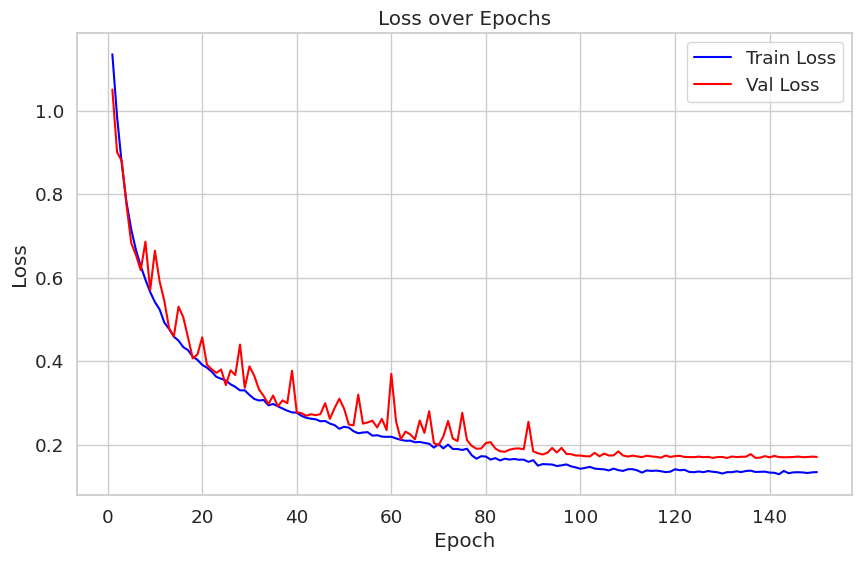

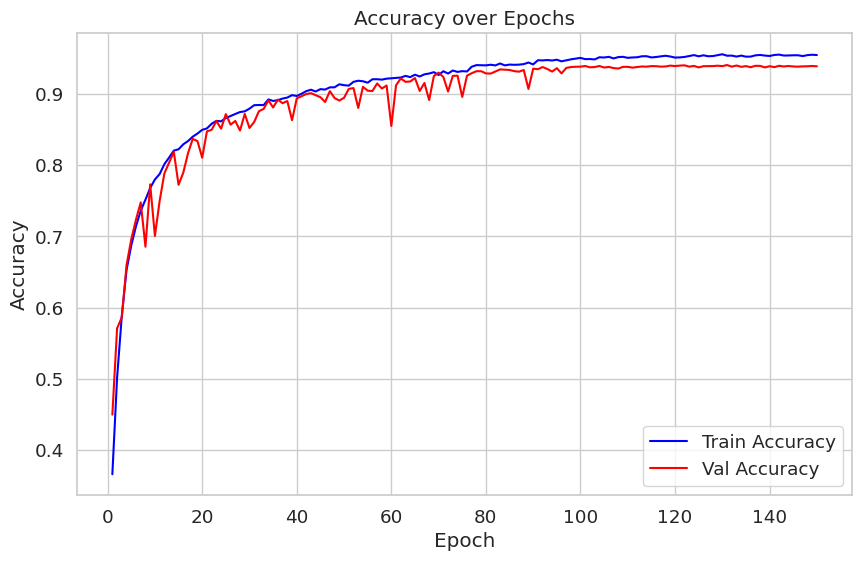

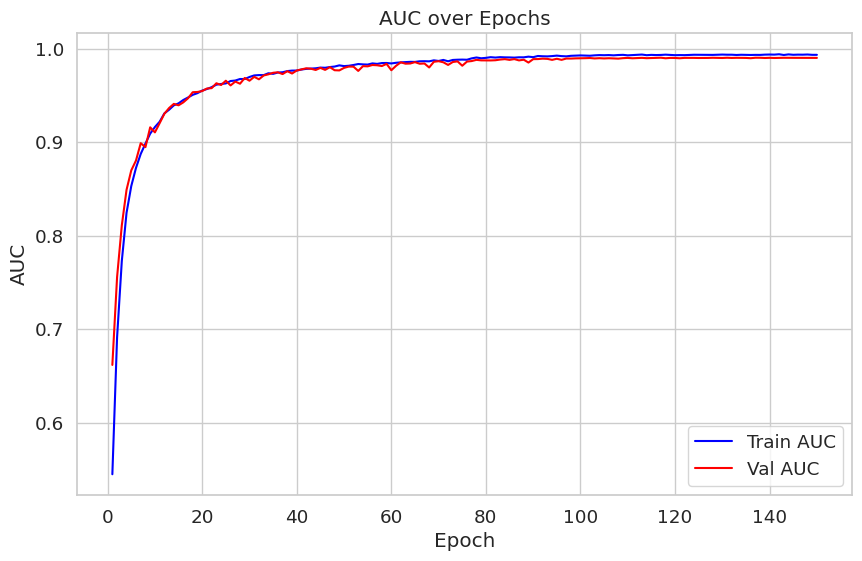

In [13]:
sns.set(style="whitegrid", font_scale=1.2)
epochs = range(1, num_epochs + 1)

# 🎨 Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'Losses.png'))
plt.show()

# 🎨 Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'Accuracies.png'))
plt.show()

# 🎨 Plot AUC
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_aucs, label='Train AUC', color='blue')
plt.plot(epochs, val_aucs, label='Val AUC', color='red')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'AUC.png'))
plt.show()

## Evaluation

Accuracy: 93.85%


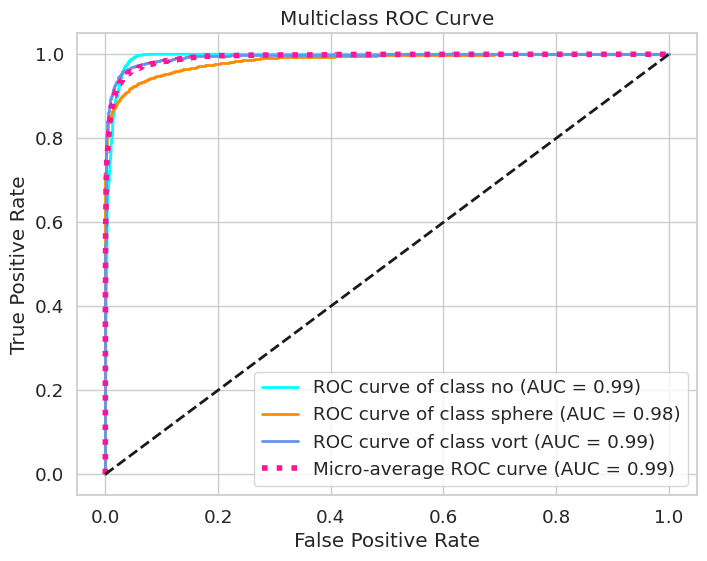

AUC (One-vs-Rest, macro-average): 0.99
AUC (One-vs-Rest, micro-average): 0.99
AUC (One-vs-Rest, weighted-average): 0.99


In [14]:
state_dict = torch.load("/kaggle/working/best_vit_model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)

all_probs_test = []
all_labels_test = []
val_correct, val_total = 0, 0

with torch.no_grad():
    for batch_data, batch_labels in val_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        outputs = model(batch_data)

        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == batch_labels).sum().item()
        val_total += batch_labels.size(0)

        probs = torch.softmax(outputs, dim=1)
        all_probs_test.extend(probs.cpu().detach().numpy())
        all_labels_test.extend(batch_labels.cpu().numpy())

val_acc = val_correct / val_total
print(f"Accuracy: {(val_acc*100):.2f}%")

# Step 1: Binarize the labels
all_labels_test = np.array(all_labels_test)
all_probs_test = np.array(all_probs_test)

n_classes = len(np.unique(all_labels_test))
all_labels_test_bin = label_binarize(all_labels_test, classes=np.arange(n_classes))

# Step 2: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_test_bin[:, i], all_probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_test_bin.ravel(), all_probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Step 4: Plot ROC curves
label_map = {0:"no", 1:"sphere", 2: "vort"}
plt.figure(figsize=(8, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {label_map[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"], color="deeppink", linestyle=":", linewidth=4,
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.savefig(os.path.join(save_dir, 'ROC_curve.png'))
plt.show()

# Step 5: Compute AUC using roc_auc_score with multi_class='ovr'
val_auc = roc_auc_score(all_labels_test, all_probs_test, multi_class='ovr')
print(f"AUC (One-vs-Rest, macro-average): {val_auc:.2f}")

# Optional: Compute AUC with different averaging methods
val_auc_micro = roc_auc_score(all_labels_test, all_probs_test, multi_class='ovr', average='micro')
val_auc_weighted = roc_auc_score(all_labels_test, all_probs_test, multi_class='ovr', average='weighted')
print(f"AUC (One-vs-Rest, micro-average): {val_auc_micro:.2f}")
print(f"AUC (One-vs-Rest, weighted-average): {val_auc_weighted:.2f}")